# **Лабораторная работа №7 (Проведение исследований с моделями семантической сегментации)**

Установка библиотек

In [ ]:
!pip install segmentation_models_pytorch torchmetrics kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseymarchenko","key":"fa052b6c963aff97173805488e484a51"}'}

Загрузка датасета с Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d trainingdatapro/roads-segmentation-dataset
!unzip roads-segmentation-dataset.zip -d ./data/

Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/roads-segmentation-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
  0% 0.00/16.0M [00:00<?, ?B/s]
100% 16.0M/16.0M [00:00<00:00, 595MB/s]
Archive:  roads-segmentation-dataset.zip
  inflating: ./data/annotations.xml  
  inflating: ./data/images/0.png     
  inflating: ./data/images/1.png     
  inflating: ./data/images/10.png    
  inflating: ./data/images/11.png    
  inflating: ./data/images/12.png    
  inflating: ./data/images/13.png    
  inflating: ./data/images/14.png    
  inflating: ./data/images/15.png    
  inflating: ./data/images/16.png    
  inflating: ./data/images/17.png    
  inflating: ./data/images/18.png    
  inflating: ./data/images/19.png    
  inflating: ./data/images/2.png     
  inflating: ./data/images/20.png    
  inflating: ./data/images/21.png    
  inflating: ./data/images/22.png    
  inflating: ./data/images/23.png    
  inflating: ./data/images/

Подготовка данных

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Трансформации только для изображений
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация ImageNet
])

# Трансформации только для масок
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        mask = np.array(mask)
        mask = (mask > 128).astype(np.float32)
        mask = Image.fromarray(mask)

        # Применение трансформаций
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Создание датасета с разными трансформациями
dataset = RoadDataset(
    image_dir='./data/images',
    mask_dir='./data/masks',
    image_transform=image_transforms,
    mask_transform=mask_transforms
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Определение моделей

In [ ]:
import segmentation_models_pytorch as smp

# U-Net (CNN)
model_unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Обучение модели

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet.to(device)

criterion = smp.losses.DiceLoss('binary')
optimizer = optim.Adam(model_unet.parameters(), lr=0.001)

# Обучение
for epoch in range(10):
    model_unet.train()
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_unet(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.5707
Epoch 2, Loss: 0.4944
Epoch 3, Loss: 0.4592
Epoch 4, Loss: 0.3894
Epoch 5, Loss: 0.3750
Epoch 6, Loss: 0.3419
Epoch 7, Loss: 0.3269
Epoch 8, Loss: 0.3132
Epoch 9, Loss: 0.3164
Epoch 10, Loss: 0.2739


Оценка метрик

In [ ]:
from torchmetrics import JaccardIndex, Accuracy, Precision, Recall

# Перемещаем модель на устройство (GPU)
model_unet.eval()
model_unet.to(device)

# Создаем метрики и сразу перемещаем их на устройство
iou = JaccardIndex(task="binary").to(device)
pixel_acc = Accuracy(task="binary").to(device)
precision = Precision(task="binary").to(device)
recall = Recall(task="binary").to(device)

with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model_unet(images)
        preds = torch.sigmoid(outputs) > 0.5
        masks = (masks > 0.5).float()

        iou.update(preds, masks)
        pixel_acc.update(preds, masks)
        precision.update(preds, masks)
        recall.update(preds, masks)

print(f"IoU: {iou.compute().item():.4f}")
print(f"Pixel Accuracy: {pixel_acc.compute().item():.4f}")
print(f"Precision: {precision.compute().item():.4f}")
print(f"Recall: {recall.compute().item():.4f}")

IoU: 0.7641
Pixel Accuracy: 0.9254
Precision: 0.7831
Recall: 0.9693


Функция для визуализации результата

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(image, mask, pred):
    # Обратная нормализация
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    image_denorm = image * std + mean

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image_denorm.permute(1, 2, 0).cpu().numpy())

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask.cpu().numpy()[0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred.cpu().numpy()[0], cmap='gray')
    plt.show()

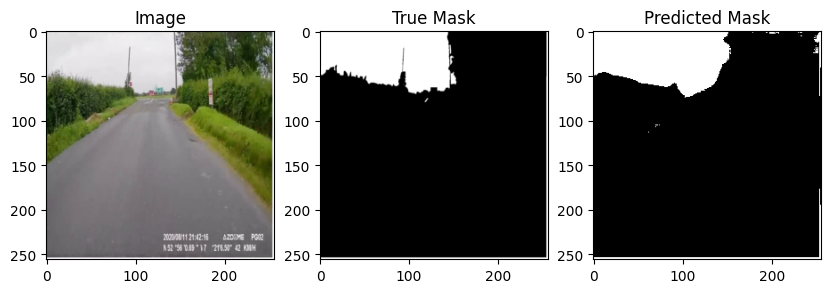

In [ ]:
# Визуализация для U-Net
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Предсказание с U-Net (используем порог 0.5, как раньше)
model_unet.eval()
with torch.no_grad():
    outputs = model_unet(images)
    preds = torch.sigmoid(outputs) > 0.5

visualize_sample(images[0], masks[0], preds[0])

In [ ]:
from torchvision import transforms

# Трансформации с аугментациями только для изображений
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
    ], p=0.5)
])

# Трансформации для масок (без аугментаций)
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

Новая модель с ResNet50

In [ ]:
import segmentation_models_pytorch as smp

model_deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

# Перемещаем на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deeplab.to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
# Оптимизатор и планировщик
optimizer = optim.AdamW(model_deeplab.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = smp.losses.DiceLoss('binary')

Обучение с аугментациями и новой моделью

In [ ]:
for epoch in range(20):  # Увеличено количество эпох
    model_deeplab.train()
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_deeplab(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.5124
Epoch 2, Loss: 0.4329
Epoch 3, Loss: 0.3544
Epoch 4, Loss: 0.2898
Epoch 5, Loss: 0.2661
Epoch 6, Loss: 0.2735
Epoch 7, Loss: 0.2544
Epoch 8, Loss: 0.2051
Epoch 9, Loss: 0.2026
Epoch 10, Loss: 0.2036
Epoch 11, Loss: 0.2091
Epoch 12, Loss: 0.1919
Epoch 13, Loss: 0.1745
Epoch 14, Loss: 0.1718
Epoch 15, Loss: 0.1559
Epoch 16, Loss: 0.1592
Epoch 17, Loss: 0.1352
Epoch 18, Loss: 0.1367
Epoch 19, Loss: 0.1375
Epoch 20, Loss: 0.1532


Метрики для улучшенной модели

In [ ]:
iou_deeplab = JaccardIndex(task="binary").to(device)
pixel_acc_deeplab = Accuracy(task="binary").to(device)
precision_deeplab = Precision(task="binary").to(device)
recall_deeplab = Recall(task="binary").to(device)

threshold = 0.6  # Оптимизированный порог

model_deeplab.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_deeplab(images)
        preds = torch.sigmoid(outputs) > threshold
        masks = (masks > 0.5).float()
        iou_deeplab.update(preds, masks)
        pixel_acc_deeplab.update(preds, masks)
        precision_deeplab.update(preds, masks)
        recall_deeplab.update(preds, masks)

# Вывод метрик
print(f"Improved IoU: {iou_deeplab.compute().item():.4f}")
print(f"Improved Pixel Accuracy: {pixel_acc_deeplab.compute().item():.4f}")
print(f"Improved Precision: {precision_deeplab.compute().item():.4f}")
print(f"Improved Recall: {recall_deeplab.compute().item():.4f}")

Improved IoU: 0.8933
Improved Pixel Accuracy: 0.9718
Improved Precision: 0.9402
Improved Recall: 0.9470


Сравнение базовой и улучшенной моделей

In [ ]:

print("Сравнение результатов:")
print("| Метрика         | Бейзлайн (U-Net) | Улучшенный бейзлайн (DeepLabV3+) |")
print("|-----------------|------------------|----------------------------------|")
print(f"| IoU             | {iou.compute().item():.4f}           | {iou_deeplab.compute().item():.4f}       |")
print(f"| Precision       | {precision.compute().item():.4f}           | {precision_deeplab.compute().item():.4f}       |")
print(f"| Recall          | {recall.compute().item():.4f}           | {recall_deeplab.compute().item():.4f}       |")
print(f"| Accuracy        | {pixel_acc.compute().item():.4f}           | {pixel_acc_deeplab.compute().item():.4f}       |")

Сравнение результатов:
| Метрика         | Бейзлайн (U-Net) | Улучшенный бейзлайн (DeepLabV3+) |
|-----------------|------------------|----------------------------------|
| IoU             | 0.7641           | 0.8933       |
| Precision       | 0.7831           | 0.9402       |
| Recall          | 0.9693           | 0.9470       |
| Accuracy        | 0.9254           | 0.9718       |


Визуализация для DeepLabV3+

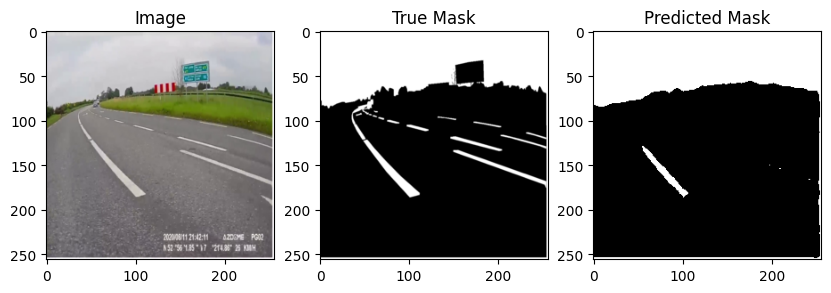

In [ ]:
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Предсказание с DeepLabV3+ (используем порог 0.6)
model_deeplab.eval()
with torch.no_grad():
    outputs = model_deeplab(images)
    preds = torch.sigmoid(outputs) > 0.6  # Порог 0.6 для улучшенной модели

# Визуализация
visualize_sample(images[0], masks[0], preds[0])

Собственная имплементация

In [ ]:
import torch
import torch.nn as nn

# Блок кодирования (Down Block)
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        skip = x
        x = self.pool(x)
        return x, skip

# Блок декодирования (Up Block)
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        return x

# Полная U-Net
class MyUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.down1 = DownBlock(in_channels, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        self.up4 = UpBlock(1024, 512)
        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)

        x = self.bottleneck(x)

        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)

        return torch.sigmoid(self.final_conv(x))

Инициализация модели и обучение

In [ ]:
model_custom = MyUNet().to(device)

# Оптимизатор и критерий
optimizer = optim.AdamW(model_custom.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.BCELoss()  # Binary Cross-Entropy для бинарной сегментации

for epoch in range(10):
    model_custom.train()
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_custom(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.5050
Epoch 2, Loss: 0.3696
Epoch 3, Loss: 0.3081
Epoch 4, Loss: 0.2873
Epoch 5, Loss: 0.2598
Epoch 6, Loss: 0.2411
Epoch 7, Loss: 0.2436
Epoch 8, Loss: 0.2254
Epoch 9, Loss: 0.2181
Epoch 10, Loss: 0.2149


Метрики

In [ ]:
iou_custom = JaccardIndex(task="binary").to(device)
pixel_acc_custom = Accuracy(task="binary").to(device)
precision_custom = Precision(task="binary").to(device)
recall_custom = Recall(task="binary").to(device)

model_custom.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_custom(images)
        preds = (outputs > 0.5).float()
        masks = (masks > 0.5).float()
        iou_custom.update(preds, masks)
        pixel_acc_custom.update(preds, masks)
        precision_custom.update(preds, masks)
        recall_custom.update(preds, masks)

print(f"Custom IoU: {iou_custom.compute().item():.4f}")
print(f"Custom Pixel Accuracy: {pixel_acc_custom.compute().item():.4f}")
print(f"Custom Precision: {precision_custom.compute().item():.4f}")
print(f"Custom Recall: {recall_custom.compute().item():.4f}")

Custom IoU: 0.8664
Custom Pixel Accuracy: 0.9631
Custom Precision: 0.9004
Custom Recall: 0.9582


Сравнение базовой и самописной моделей

In [ ]:
print("Сравнение результатов:")
print("| Метрика         | Бейзлайн (U-Net) | Самописная (MyUNet) |")
print("|-----------------|------------------|---------------------|")
print(f"| IoU             | {iou.compute().item():.4f}           | {iou_custom.compute().item():.4f}       |")
print(f"| Precision       | {precision.compute().item():.4f}           | {pixel_acc_custom.compute().item():.4f}       |")
print(f"| Recall          | {recall.compute().item():.4f}           | {precision_custom.compute().item():.4f}       |")
print(f"| Accuracy        | {pixel_acc.compute().item():.4f}           | {recall_custom.compute().item():.4f}       |")

Сравнение результатов:
| Метрика         | Бейзлайн (U-Net) | Самописная (MyUNet) |
|-----------------|------------------|---------------------|
| IoU             | 0.7641           | 0.8664       |
| Precision       | 0.7831           | 0.9631       |
| Recall          | 0.9693           | 0.9004       |
| Accuracy        | 0.9254           | 0.9582       |


Визуализация для MyUnet

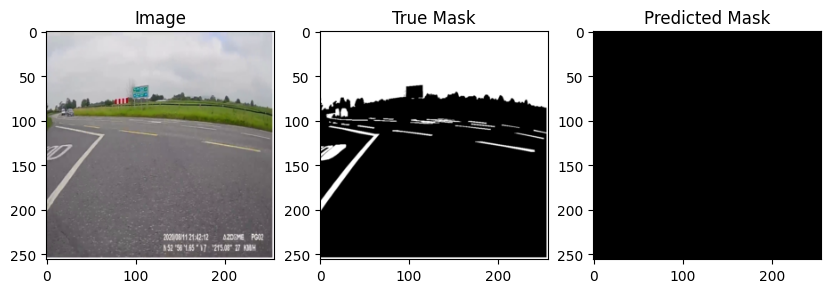

In [ ]:
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Предсказание с MyUnet (используем порог 0.5)
model_custom.eval()
with torch.no_grad():
    outputs = model_custom(images)
    preds = torch.sigmoid(outputs) > 0.5

# Визуализация
visualize_sample(images[0], masks[0], preds[0])

In [ ]:
from torchvision import transforms

# Трансформации с аугментациями только для изображений
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
    ], p=0.5)
])

# Трансформации для масок (без аугментаций)
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

Инициализация улучшенной собственной модели и обучение

In [ ]:
model_custom = MyUNet().to(device)

# Оптимизатор и планировщик
optimizer = optim.AdamW(model_custom.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.BCELoss()

for epoch in range(20):
    model_custom.train()
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_custom(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.46116453409194946
Epoch 2, Loss: 0.33252355456352234
Epoch 3, Loss: 0.2860167324542999
Epoch 4, Loss: 0.27321359515190125
Epoch 5, Loss: 0.25377437472343445
Epoch 6, Loss: 0.24255412817001343
Epoch 7, Loss: 0.24029181897640228
Epoch 8, Loss: 0.22715796530246735
Epoch 9, Loss: 0.2143750786781311
Epoch 10, Loss: 0.20714662969112396
Epoch 11, Loss: 0.214386448264122
Epoch 12, Loss: 0.21483542025089264
Epoch 13, Loss: 0.2018900066614151
Epoch 14, Loss: 0.19304947555065155
Epoch 15, Loss: 0.21083033084869385
Epoch 16, Loss: 0.19409792125225067
Epoch 17, Loss: 0.18364782631397247
Epoch 18, Loss: 0.1781102865934372
Epoch 19, Loss: 0.18084339797496796
Epoch 20, Loss: 0.17182596027851105


Метрики

In [ ]:

iou_custom_deeplab = JaccardIndex(task="binary").to(device)
pixel_acc_custom_deeplab = Accuracy(task="binary").to(device)
precision_custom_deeplab = Precision(task="binary").to(device)
recall_custom_deeplab = Recall(task="binary").to(device)

model_custom.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_custom(images)
        preds = (outputs > 0.6).float()  # Порог 0.6
        masks = (masks > 0.5).float()
        iou_custom_deeplab.update(preds, masks)
        pixel_acc_custom_deeplab.update(preds, masks)
        precision_custom_deeplab.update(preds, masks)
        recall_custom_deeplab.update(preds, masks)

print(f"Custom IoU (с улучшениями): {iou_custom_deeplab.compute().item():.4f}")
print(f"Custom Pixel Accuracy (с улучшениями): {pixel_acc_custom_deeplab.compute().item():.4f}")
print(f"Custom Precision (с улучшениями): {precision_custom_deeplab.compute().item():.4f}")
print(f"Custom Recall (с улучшениями): {recall_custom_deeplab.compute().item():.4f}")

Custom IoU (с улучшениями): 0.9478
Custom Pixel Accuracy (с улучшениями): 0.9866
Custom Precision (с улучшениями): 0.9733
Custom Recall (с улучшениями): 0.9731


Сравнение улучшенной и улучшенной самописной моделей

In [ ]:
print("Сравнение результатов:")
print("| Метрика         | Улучшенный бейзлайн (DeepLabV3+) | Улучшенная самописная (DeepLabV3+) |")
print("|-----------------|----------------------------------|---------------------|")
print(f"| IoU             | {iou_deeplab.compute().item():.4f}                           | {iou_custom_deeplab.compute().item():.4f}       |")
print(f"| Precision       | {precision_deeplab.compute().item():.4f}                           | {precision_custom_deeplab.compute().item():.4f}       |")
print(f"| Recall          | {recall_deeplab.compute().item():.4f}                           | {recall_custom_deeplab.compute().item():.4f}       |")
print(f"| Accuracy        | {pixel_acc_deeplab.compute().item():.4f}                           | {pixel_acc_custom_deeplab.compute().item():.4f}       |")

Сравнение результатов:
| Метрика         | Улучшенный бейзлайн (DeepLabV3+) | Улучшенная самописная (DeepLabV3+) |
|-----------------|----------------------------------|---------------------|
| IoU             | 0.8933                           | 0.9478       |
| Precision       | 0.9402                           | 0.9733       |
| Recall          | 0.9470                           | 0.9731       |
| Accuracy        | 0.9718                           | 0.9866       |


Визуализация результатов

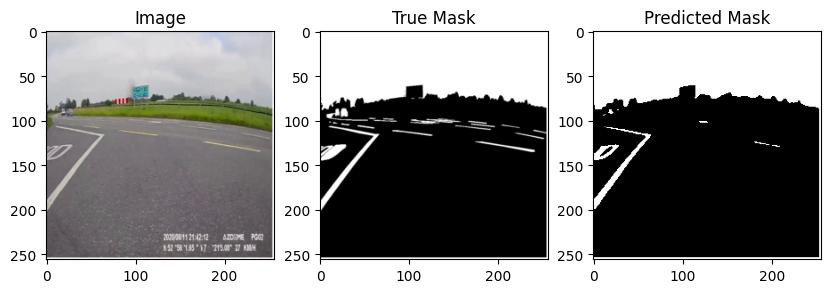

In [ ]:
# Получение случайного примера
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)

# Предсказание модели
model_custom.eval()
with torch.no_grad():
    outputs = model_custom(images)
    preds = (outputs > 0.6).float()  # Порог 0.6

# Визуализация
visualize_sample(images[0], masks[0], preds[0])